## Introduction

The data set that I study contains information and statistics of Major League Baseball (MLB) pitchers in the 2019 regular season, which is available on the *Baseball-Reference* website. *Baseball-Reference* is a website that collects statistics in MLB and is widely referenced by media organizations and baseball broadcasters as a source for statistics.  

There has been a lot of research on baseball statistics to help analyze player performance. And one question that may be asked by looking at pitcher statistics is what distinguishes a starting pitcher from a relief pitcher. In general, a starting pitcher is expected to start the game for the team and pitch through a significant portion of the game. Relief pitchers are expected to take over from the starting pitcher during mid or late game and finish the game. Teams usually play several relief pitchers in a game since different relief pitchers are good at handling different situations.  

In this project, first I clean and preprocess the data set collected from the *Baseball-Reference* website. Then I perform PCA on the data set to obtain a lower dimensional representation of the data set. At the end, I run logistic regression on the original data set and the projected data set onto principal components to see if there is a difference in the regression result. 

## Data Cleaning and Preprocessing

The data set is a compilation of four tables:  

- The *pitching_ratio* table (https://www.baseball-reference.com/leagues/MLB/2019-ratio-pitching.shtml) contains statistics computed in terms of ratios, e.g. strikeout percentage, base on balls percentage, groundout to flyout ratio, etc.  

- The *standard_pitching* table (https://www.baseball-reference.com/leagues/MLB/2019-standard-pitching.shtml) contains some of the most common statistics for pitchers, e.g. earned run average (ERA), win/loss, field independent pitching (FIP), etc.  

- The *win_probability* table (https://www.baseball-reference.com/leagues/MLB/2019-win_probability-pitching.shtml) contains statistics that are used to evaluate a pitcher's contribution to a win.  

- And the *pitches* table (https://www.baseball-reference.com/leagues/MLB/2019-pitches-pitching.shtml) contains statistics of pitches that a pitcher throws.    

The merged data set contains 831 rows and 56 columns, which means it has information about 831 pitchers that played in the 2019 MLB regular season and 56 statistics for each pitcher. However, there are missing entries in the data set and for PCA to work properly, I drop all the rows with any missing entries in the columns. Besides, I drop the *Rk* columns since it is merely an index for the table and does not carry any concrete information. I also change names for several columns for clarity. After data cleaning, there are 650 rows and 55 columns left.

The data set does not label each pitcher as a starting pitcher or a relief pitcher. It would require a lot of work to manually check if a pitcher is actually a starting pitcher or a relief pitcher for all the pitchers in the data set. Therefore I look at the *GS* column since it tells us the number of games that a pitcher starts. We know that a starting pitcher usally starts a game for the team, so it is expected that a starting pitcher has a higher number in the *GS* column. Here, I choose a threshold of 20: if a pitcher has a value of at least 20 in the *GS* column, then the pitcher is considered as a starting pitcher and has a value of 1 in the *Pitcher Role* column. Otherwise, the pitcher is considered as a relief pitcher and has a value of 0 in the *Pitcher Role* column.  

The reason for this threshold is that there are 162 games in the entire regular season for each team and a starting pitcher generally pitches one game and rests for four games. This means that if a starting pitcher is healthy throughout the whole season, then he is expected to start 32 to 33 games. But due to injuries, many starting pitchers cannot reach the 32/33 mark, but most of them are able to deliver at least 20 starts. Using this threshold, there are 113 starting pitchers and 537 relief pitchers in the data set. 

To apply PCA, the feature matrix X contains only numeric columns, so I combine numeric columns in the data set to get the feature matrix X (*pitching*). The feature matrix is 650 by 50. 

Another thing to notice is that even though some of the columns contain percentage information, which are numeric, they are presented as strings with a percentage mark (%), so I need to convert these strings into corresponding floats.

## Principal Component Analysis

The idea of Principal Component Analysis can be described as follows: Given data points $\{\textbf{x}_1, ..., \textbf{x}_N\}$ in $R^m$, we attempt to find a $d$-dimensional affine subspace $\mathcal{A} = \mu + V \subseteq R^m$ such that the sum of least squares distance from the $\textbf{x}_j$ to $\mathcal{A}$ is minimized. By **Theorem 1.23** in the lecture notes, we know that the sum of least squares distance is minimized with $\mu = \overline{\textbf{x}}_N$, where $\overline{\textbf{x}}_N$ is the sample mean, and with $V$ equal to the span of the $d$ eigenvectors of the sample covariance $C$ corresponding to its $d$ largest eigenvalues. 

However, before delving into PCA, it is worth considering what is the appropriate $d$ for the $d$-dimensional subspace we are looking for. We know from **Theorem 2.47** that if $X$ is a $m \times N$ matrix with entries having mean 0 and variance 1, then the eigenvalues of a Wishart Matrix $W = \frac{1}{N} X^TX$ follow the Marcenko–Pastur density $f_{\rho}(x)$, given by:
$$
f_{\rho}(x) = \frac{\sqrt{(x - \rho_-)(\rho_+ - x)}}{2\pi x}\text{, for $x \in [\rho_-, \rho_+]$ and 0 otherwise.}
$$
where $\rho_\pm = (1 \pm \sqrt{\rho})^2$. Furthermore, by the discussion on Spiked Covariance Models, if $W = \frac{1}{N} X^TCX$ where $C = I_m + D_r$ is some low rank perturbation of the identity matrix, then there would be outliers in the distribution of eigenvalues of $W$.

Therefore I compute the Wishart matrix $W = \frac{1}{N} X^TX$ where $X$ is the centered feature matrix of the data set and find the distribution of its eigenvalues. 

I also try to superimpose the Marcenko–Pastur density on the histogram of eigenvalues to see if they match. However, Marcenko-Pastur density assumes that we have standard normal noise in data, but in real world data set this may not be the case. Hence there should be a scaling factor $\sigma$ in the distribution of noise $N(0, \sigma I_m)$. This also leads to a scaled and dilated Marcenko–Pastur density given by:
$$
\frac{1}{\sigma^2}f_{\rho}(\frac{x}{\sigma^2})
$$
Therefore I superimpose rather this scaled and dilated version of the Marchenko-Pastur density and test several values of $\sigma$ to see which best matches my data set. The picture for the distribution is shown below. A zoomed-in picture is also shown below.

It turns out that there is no $\sigma$ that best matches the data set. Even though in my case, $\rho = \frac{m}{N} > 1$, there is also a spike at 0 in the distribution of eigenvalues and the best possible value $\sigma = 5$ only barely works. Overall, the distribution of eigenvalues is closer to the power law. This means that there is some correlation among columns of the data set. I believe that this is expected since it makes sense to think that a pitcher that has a good number in one statistics is more likely to have a good number in other statistics as well. For example, a pitcher that has a lower ERA (giving up fewer earned runs to the opponent on average) may be more likely to have a lower WHIP (giving up fewer hits and walks on average). 

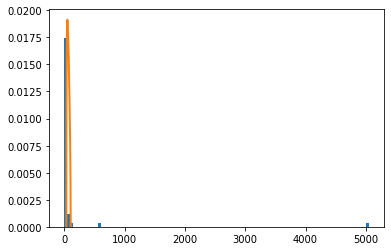

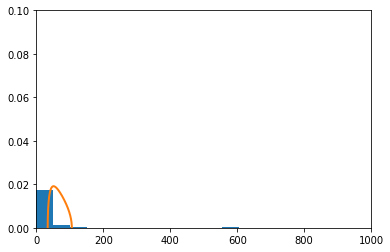

We can see that there are two outliers of eigenvalues in the histogram, one just less than 600 and another nearly 5000. Therefore a good choice of dimension $d$ would be 2.  

It is stated before that PCA can be interpreted as finding a $d$-dimensional affine subspace that minimizes the sum of least squares errors. This can be formulated as the following minimization problem:
$$
argmin \sum_{j=1}^{N} ||\textbf{x}_j - (\mu + Q\beta_j)||^2
$$
where minimization runs over all $\mu \in R^m, \beta_j \in R^d, Q \in M_{m \times d} \ s.t. Q^TQ = I_d$. Again by **Theorem 1.23** and **Proposition 1.31**, the minimizers are $\mu = \overline{\textbf{x}}_N, \beta_j = Q^T(\textbf{x}_j - \overline{\textbf{x}}_N)$, and Q is given by the left most $d$ columns of $U$ in the Singular Value Decomposition of $\hat{X} = U\Sigma V$ where $\hat{X}$ is the $m \times N$ matrix whose columns are centered data points scaled by $\frac{1}{\sqrt{N}}$.   

$\overline{\beta}_N = Q^T\overline{\textbf{x}}_N$ is the rank-2 principal mean and $\beta_j$'s are the rank-2 principal coordinates. I use these two quantities to construct the 2-dimensional projection of the data set onto its principal components. The picture of the projected data is shown below.

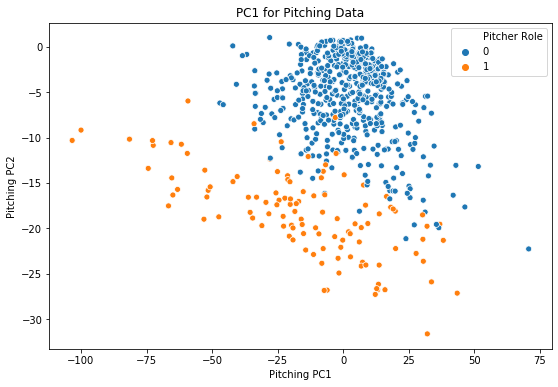

Recall that label 1 represents starting pitchers and label 0 represents relief pitchers. We can see from the plot that there these two groups of pitchers form pretty clear clusters in the projected data. However, perfect classification might not be possible since there is still overlap between these two clusters.  

## Logistic Regression

For the final part, I try to run logistic regression on the original data set and on the projected data set onto the best-fit 2-dimensional affine subspace. I split the data set into 20 folds (with shuffling). Each fold is then used once as a validation while the 19 remaining folds form the training set. Then I compute the average accuracy score for using non-PCA-ed data and using PCA-ed data.

The logistic regression model performs almost equally well on PCA-ed and non-PCA-ed data set with both having accuracy score of 96%. This shows that the data set itself already has a pretty clear decision boundary between starting pitchers and relief pitchers. Then it makes sense that using PCA-ed data set gives a somewhat similar result in logistic regression.

## Python Code

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Import datasets
pitching_ratio = pd.read_csv('Pitching Data/Pitching Ratio.csv')
standard_pitching = pd.read_csv('Pitching Data/Standard Pitching.csv')
win_probability = pd.read_csv('Pitching Data/Win Probability.csv')
pitches = pd.read_csv('Pitching Data/Pitches.csv')

In [3]:
# Merge datasets
cols = pitching_ratio.columns.difference(standard_pitching.columns)
df = pd.merge(standard_pitching, pitching_ratio[cols], left_index = True, right_index = True)

cols = win_probability.columns.difference(df.columns)
df = pd.merge(df, win_probability[cols], left_index = True, right_index = True)

cols = pitches.columns.difference(df.columns)
df = pd.merge(df, pitches[cols], left_index = True, right_index = True)
df.shape

(831, 56)

In [4]:
# Select a subset of data to run analysis, drop missing data and irrelevant columns
# rename some columns for clarification
df = df[~df.isnull().any(axis = 1)]
df = df.drop(columns = ['Rk'])
df = df.rename(columns = {'Lg': 'League', 'Tm': 'Team'})
df.shape

(650, 55)

In [5]:
# Define pitcher roles (starting pitcher vs. relief pitcher)
df['Pitcher Role'] = df['GS'].apply(lambda x: 1 if x >= 20 else 0)
df.head()

,Name,Age,Team,League,GS,W,L,W-L%,ERA,FIP,...,AS/Str,Con,F/Str,I/Str,L/SO%,L/Str,Pit/PA,S/Str,Str%,Pitcher Role
0,Fernando Abad*\abadfe01,33,SFG,NL,0,0,2,0.000,4.15,4.52,...,62.20%,73.90%,12.60%,33.30%,66.70%,37.80%,3.49,16.20%,64.90%,0
2,Jason Adam\adamja01,27,TOR,AL,0,3,0,1.000,2.91,3.95,...,77.70%,71.90%,29.70%,26.20%,27.80%,22.30%,4.36,21.80%,57.70%,0
4,Austin Adams\adamsau02,28,TOT,MLB,2,2,2,0.500,3.94,3.12,...,70.90%,59.80%,24.60%,17.80%,26.40%,29.10%,4.16,28.50%,62.30%,0
5,Chance Adams\adamsch01,24,NYY,AL,0,1,1,0.500,8.53,6.53,...,75.70%,81.90%,33.90%,28.10%,30.40%,24.30%,4.19,13.70%,60.30%,0
7,Dario Agrazal\agrazda01,24,PIT,NL,14,4,5,0.444,4.91,5.90,...,70.90%,84.10%,25.70%,33.90%,43.90%,29.10%,3.58,11.30%,64.70%,0


In [6]:
df['Pitcher Role'].value_counts()

0    537
1    113
Name: Pitcher Role, dtype: int64

In [7]:
# Combine numeric columns into the feature matrix 
player = df[['Name', 'Team', 'League', 'Age', 'Pitcher Role']]
pitching = df.drop(['Name', 'Team', 'League', 'Age', 'GS', 'Pitcher Role'], axis = 1)
pitching.shape

(650, 50)

In [8]:
# Convert percentage info into float
for col in pitching.columns:
    if pitching[col].dtypes == 'O':
        pitching[col] = pitching[col].apply(lambda x: float(x.strip('%')) / 100)

In [9]:
# Center the data
pitching_mean = pitching.mean()
centered_pitching = (pitching - pitching_mean)

In [10]:
# Compute eigenvalues of the Wishart matrix
m, N = centered_pitching.shape
C = 1/N * centered_pitching.T @ centered_pitching
eigvals, eigvecs = np.linalg.eig(C) 

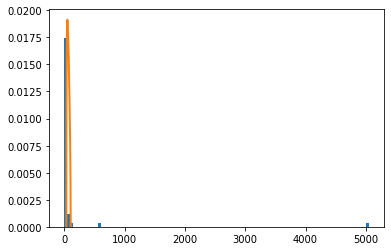

In [11]:
# Look at the distribution and superimpose scaled and dilated Marchenko-Pastur density
r = m / N
sigma_2 = 5
a = ((1 - np.sqrt(r)) ** 2) * sigma_2
b = ((1 + np.sqrt(r)) ** 2) * sigma_2
x = np.arange(a, b, 0.0001)  #some random value for x axis
y = 1 / (sigma_2) * np.sqrt((x - a) * (b - x)) / (2 * np.pi * x) #y=f(x)

plt.hist(eigvals, density = True, bins  = 100)
plt.plot(x, y, lw = 2) 
plt.show()

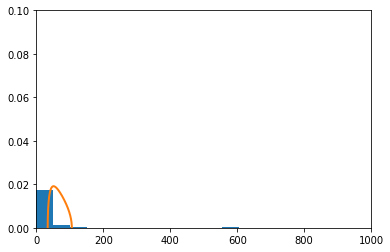

In [12]:
#Zoom in to see better near 0
plt.hist(eigvals, density = True, bins  = 100)
plt.plot(x, y, lw = 2) 
plt.axis([0, 1000, 0, 0.1])
plt.show()

In [13]:
# Run PCA
N = pitching.shape[0]
pitching_mean = pitching.mean()
normalized_pitching = (pitching - pitching_mean) / np.sqrt(N)
normalized_pitching = normalized_pitching.T
u, s, vt = np.linalg.svd(normalized_pitching, full_matrices = False)
Q = u[:, np.array((0, 1))]
mu = pitching.mean().to_numpy()
mu.shape = (mu.size, 1)

In [14]:
# Project data set onto principal components
beta_2d = (np.sqrt(N) * Q.T @ normalized_pitching).to_numpy()
beta_bar = Q.T @ mu
pitching_2d = beta_2d + beta_bar

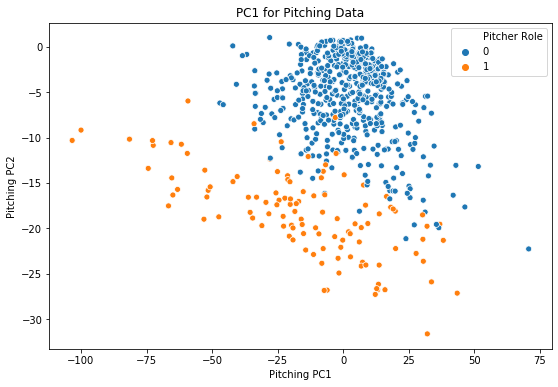

In [15]:
# Plot the projected data, hued by Pitcher Role (Starter vs. Non-Starter)
plt.figure(figsize = (9, 6))
plt.title("PC1 for Pitching Data")
plt.xlabel("Pitching PC1")
plt.ylabel("Pitching PC2")
sns.scatterplot(x = pitching_2d[0, :], y = pitching_2d[1, :], hue = player['Pitcher Role'])

In [16]:
# Split the data set into 20 folds
kf = KFold(n_splits = 20, shuffle = True)

In [17]:
# Run logistic regression on the 20 folds.
non_pca_score = [] 
pca_score = []

for train_index, test_index in kf.split(pitching):
    
    # Get the train/test sets
    X_train = pitching.iloc[train_index]
    X_test = pitching.iloc[test_index]
    y_train = player['Pitcher Role'].iloc[train_index]
    y_test = player['Pitcher Role'].iloc[test_index]
    
    # Fit logistic regression on non-PCA-ed data set
    logit_non_pca = LogisticRegression().fit(X_train, y_train)
    non_pca_score.append(logit_non_pca.score(X_test, y_test))
    
    # Run PCA
    N = X_train.shape[0]
    X_train_mean = X_train.mean()
    normalized_X_train = (X_train - X_train_mean) / np.sqrt(N)
    normalized_X_test = (X_test - X_train_mean) / np.sqrt(N)
    normalized_X_train = normalized_X_train.T
    normalized_X_test = normalized_X_test.T
    
    u, s, vt = np.linalg.svd(normalized_X_train, full_matrices = False)
    Q = u[:, np.array((0, 1))]
    mu = X_train_mean.to_numpy()
    mu.shape = (mu.size, 1)
    
    #Project data onto principal components for both train and test set
    beta_2d = (np.sqrt(N) * Q.T @ normalized_X_train).to_numpy()
    beta_bar = Q.T @ mu
    X_train_2d = beta_2d + beta_bar
    
    beta_2d = (np.sqrt(N) * Q.T @ normalized_X_test).to_numpy()
    beta_bar = Q.T @ mu
    X_test_2d = beta_2d + beta_bar
    
    # Fit logistic regression on PCA-ed data set
    logit_pca = LogisticRegression().fit(X_train_2d.T, y_train)
    pca_score.append(logit_pca.score(X_test_2d.T, y_test))  

In [18]:
np.mean(pca_score)

0.9613636363636363

In [19]:
np.mean(non_pca_score)

0.9660984848484848